# Proyecto de Internet de las Cosas: Monitor de Ambiente (Etapa 5)

En esta quinta y última etapa utilizaremos el dispositivo Pycom GPy/Pysense para recolectar una serie de mediciones utilizando funciones definidas por el usuario. El objetivo es implementar el mismo monitor ambiental de la etapa anterior pero a través d eun programa más compacto gracias al uso de las funciones. Recordemos que la función de este monitor es continuamente supervisar los valores de las magnitudes físicas de su entorno e indicar mediante alguna alarma un cambio abrupto (anomalía de alguna de ellas).

# Conexión al nodo de Internet de las Cosas 

Antes de iniciar a recolectar los datos, debemos conectar el dispositivo a nuestra red WiFi. Debemos entonces instalar algunas liberrías específicas que luego utilizaremos para acceder a los diferentes sensores y controlar la luz LED RGB. También incluimos la librería para visualizar los datos a través de gráficas.

In [ ]:
#Librerias para interactuar con el dispositivo IoT
%pip install -i https://test.pypi.org/simple/ pycom-client-library
%pip install zeroconf
#Libreria para visualizacion de datos
%pip install matplotlib

Una vez instaladas las librerías, debemos importar la librería "pycom" que nos permitirá conectarnos a la dirección IP del dispositivo a través de WiFi. Esta dirección IP la obtenemos analizando los datos de arranque del dispositivo en otro programa. 

In [ ]:
from pycom import *

ipaddr = input("Ingrese la dirección IP del nodo:")
node = SimplePycomNode(ip=ipaddr, port=8000)

Cada dispositivo ofrece diferentes métodos (similar a lo que sucede con las cadenas) que nos permiten interactuar con sus sensores y actuadores. El método .help() nos describe las funcionalidades disponibles. En esta actividad utilzaremos sólo alguna de ellas relacionadas a la luz LED RGB, y a los sensores de temperatura, humedad y luz.

In [ ]:
node.help()

# Desarrollo de las funciones


## Detección de posición
Definimos la función *posicion_acostada(dispositivo)* que tiene como parámetro un dispositivio IoT. La función debe obtener el valor de fuerza G en el eje z y verificar si coresponde o no a una unidad (sea negativa o positiva). Sabemos que si corresponde, esto indica que el dispositivo está en la posición acostada, por lo que la función debe devolver el valor lógico verdadero (True). En cambio, si no se encuentra en dicha posición, debe devolver el valor falso (False).

In [ ]:
def posicion_acostada(dispositivo):
    #Obtenemos el valor de la gravedad en el eje z y verificamos si corresponde a 1 (acostado)
    if (abs(round(dispositivo.get('acceleration')[2]))==1):
        return True
    else:
        return False

Una vez definida la función, podemos probarla

In [ ]:
if posicion_acostada(node):
    print("Acostado")
else:
    print("No acostado")

## Registro de mediciones
Definimos la función *registrar_datos(dispositivo. datos)* que tiene como primer parámetro un dispositivo IoT y como segundo, una lista con 3 series de datos, una por cada una de las mediciones a registrar (temperatura, humedad y luz). Cada vez que la función es llamada, la misma debe realizar una nueva medición de cada uno de las 3 variables y almacenarlas en la serie de datos correspondiente.

In [ ]:
def registrar_datos(dispositivo, datos):
    datos[0].append(dispositivo.get('temperature'))    
    datos[1].append(dispositivo.get('humidity'))    
    datos[2].append(dispositivo.get('lux'))    

Una vez definida la función, podemos probarla

In [ ]:
mediciones = [[], [], []] # lista con 3 series vacias de datos (temp, hum y luz)
registrar_datos(node, mediciones)
print(mediciones)

## Análisis de últimas mediciones
Definimos la función *analizar_datos(dispositivo. datos)* que tiene por parámetro un dispositivo IoT y una lista con 3 series de datos, los cuales deben analizarse para determinar el color para encender la luz LED RGB. En el caso que los últimos valores sean considerados normales, la luz debe ser verde. Sin embargo, si se detecta una anomalía, el color debe ser rojo para indicarla al usuario.

De forma arbitraria definimos un estado de anomalía si se cumple alguna de estas condiciones:

* La temperatura es mayor a 40 grados
* Hay completa oscuridad (iluminancia menor a 10 lux)

Por otro lado, en el caso que no haya datos cargados, la luz debe ser verde,

In [ ]:
def analizar_datos(dispositivo, datos):
    verde = '0x00ff00'
    rojo = '0xff0000'
    #Si no hay datos recolectados, el estado es verde
    if (len(datos[0])==0):
        node.post('color', color=verde, duration=0.5)
    else: 
        #Analizamos si la temperatura es mayor que 40 o la luz menos a 10
        if(datos[0][-1]>40 or datos[2][-1]<10):
            node.post('color', color=rojo, duration=0.5)#Enviar senial de alarma
        else:
            node.post('color', color=verde, duration=0.5)

Para verificar la función podemos probar casos donde el estado sea normal, y el color del LED RGB sea verde, y otros casos donde exista una anomalía y el color resulte rojo.

In [ ]:
mediciones = [[], [], []]
mediciones = [[10], [10], [100]]
mediciones = [[50], [10], [100]]
mediciones = [[10], [10], [5]]
mediciones = [[50], [10], [5]]
analizar_datos(node, mediciones)


## Graficar las mediciones
Definimos la función *graficar_datos(serie, nombre)* que tiene por parámetro una serie de datos y el nombre que identifica la misma (como la variable medida). La función debe graficar las muestras contenidas en la serie para observar su variación en el tiempo. 

In [ ]:
import matplotlib.pyplot as plt
def graficar_datos(serie, nombre):
    plt.figure(figsize=(10,2))
    plt.plot(serie)
    plt.xlabel('Muestra')
    plt.ylabel(nombre)
    plt.show()

Finalmente, evaluamos la función definida a través de una prueba

In [ ]:
lista = [1, 3, 3, 4, 50, 56, 4, 3, 4, 8, 9]
graficar_datos(lista,"Valores")

# Desafío: Monitor Ambiental Alarmado (Etapa 5)

Por último vamos a utilizar las cuatro funciones anteriormente definidas para realizar nuestro programa de monitoreo ambiental. 

In [ ]:
#Utilizamos una matriz para recolectar los datos en cada una de sus filas: temp, hum y luz
data = [[], [], []]
while (posicion_acostada(node)): # Mientras este acostado ...
    analizar_datos(node, data)
    registrar_datos(node, data)
print('Fin de ejecucion recoleccion')
#Grafico de temperatura
graficar_datos(data[0],'Temperatura')
#Grafico de humedad
graficar_datos(data[1],'Humedad')
#Grafico de luz
graficar_datos(data[2],'Luz')

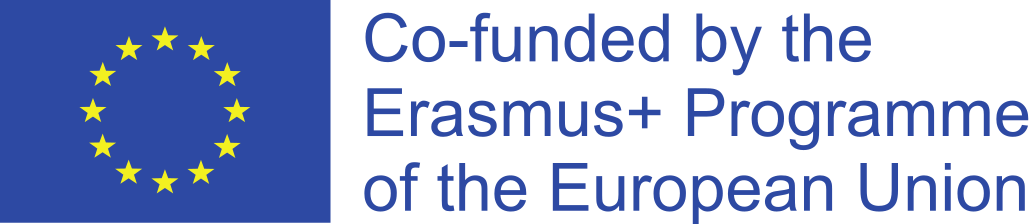